In [14]:
from datetime import datetime
import settings.config as cfg
import pandas as pd
import numpy as np


preprocessed_dataset_folder = cfg.preprocessed_dataset_folder
individual_rs_strategy = cfg.individual_rs_strategy
aggregation_strategies = cfg.aggregation_strategies
recommendations_number = cfg.recommendations_number
individual_rs_validation_folds_k = cfg.individual_rs_validation_folds_k
group_rs_evaluation_folds_k = cfg.group_rs_evaluation_folds_k
evaluation_strategy = cfg.evaluation_strategy
metrics = cfg.metrics
group_types = cfg.group_types

display(cfg.inverse_propensity_debiasing)

True

In [15]:
import pandas as pd
ratings_df = pd.read_csv(preprocessed_dataset_folder+"/ratings.csv")

import pickle

group_composition = pickle.load(open(preprocessed_dataset_folder+"/group_composition.pkl", "rb"))
display(group_composition)

{1: {'group_size': 4,
  'group_members': [26323, 42775, 41651, 32327],
  'group_similarity': 0.48538011695906436},
 10: {'group_size': 4,
  'group_members': [99855, 80934, 9488, 86840],
  'group_similarity': 0.4795321637426901},
 11: {'group_size': 4,
  'group_members': [99355, 76869, 43978, 30600],
  'group_similarity': 0.49707602339181284},
 12: {'group_size': 4,
  'group_members': [89066, 17384, 56579, 62404],
  'group_similarity': 0.4736842105263159},
 13: {'group_size': 4,
  'group_members': [66485, 31561, 31976, 53265],
  'group_similarity': 0.584795321637427},
 14: {'group_size': 2,
  'group_members': [96341, 64074],
  'group_similarity': 0.7192982456140351},
 15: {'group_size': 2,
  'group_members': [752, 73779],
  'group_similarity': 0.3333333333333333},
 16: {'group_size': 3,
  'group_members': [43778, 9371, 71238],
  'group_similarity': 0.4853801169590643},
 17: {'group_size': 4,
  'group_members': [58708, 74772, 6990, 29112],
  'group_similarity': 0.40935672514619886},
 18:

In [16]:
from lenskit.algorithms import Recommender
from lenskit.algorithms.user_knn import UserUser
from lenskit.algorithms.item_knn import ItemItem
from sklearn.model_selection import train_test_split
from lenskit import batch, topn, util
  
#Auxiliary functions
def evalAlg(aname, params, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, cfg.recommendations_number)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    recs['Params'] = params
    return recs

def hyperparam_eval(algName, training_df, paramList):    
    all_recs = []
    hp_training_df, validation_df = train_test_split(training_df, test_size=0.2, random_state=42, shuffle=True, stratify=training_df["user"])
    for param in paramList:
        if algName == "LENSKIT_CF_USER":
            alg = UserUser(param)
        elif algName == "LENSKIT_CF_ITEM":
            alg = ItemItem(param)
            
        all_recs.append(evalAlg(algName, param, alg, hp_training_df, validation_df))
    all_recs = pd.concat(all_recs, ignore_index=True)
    
    rla = topn.RecListAnalysis()
    rla.add_metric(topn.ndcg)
    results = rla.compute(all_recs, validation_df)
    mean_res = results.reset_index().groupby(["Algorithm","Params"]).mean()["ndcg"]
    maxid = mean_res.argmax()
    return mean_res.index[maxid]


# Train individual recommender system and predict ratings
def train_individual_rs_and_get_predictions(training_df, test_df):
    if cfg.individual_rs_strategy == "LENSKIT_CF_USER":
        print(cfg.individual_rs_strategy)
        return train_lenskit_cf_user_rs_and_get_predictions(training_df, test_df)
    if cfg.individual_rs_strategy == "LENSKIT_CF_ITEM":
        print(cfg.individual_rs_strategy)
        return train_lenskit_cf_item_rs_and_get_predictions(training_df, test_df)    
    return None
    


# Train lenskit CF user-user individual recommender system and predict ratings
def train_lenskit_cf_user_rs_and_get_predictions(training_df, test_df):
    if cfg.individual_rs_validation_folds_k <=0:
        print("training")        
        best_hyperparam = hyperparam_eval(cfg.individual_rs_strategy, training_df, [1,5,10,20,30,40,50])
        nNeighbors = best_hyperparam[1]
        print("nNeighbors hyperparameter:"+str(nNeighbors))
        
        user_user = UserUser(nNeighbors)  
        recsys = Recommender.adapt(user_user)
        recsys.fit(training_df)
        
        print("evaluating predictions")
        # Evaluating predictions 
        test_df['predicted_rating'] = recsys.predict(test_df)
        print("Done!")
        return test_df
    return None    

# Train lenskit CF item-item individual recommender system and predict ratings
def train_lenskit_cf_item_rs_and_get_predictions(training_df, test_df):
    if cfg.individual_rs_validation_folds_k <=0:
        print("training")
        best_hyperparam = hyperparam_eval(cfg.individual_rs_strategy, training_df, [1,5,10,20,30,40,50])
        nNeighbors = best_hyperparam[1]
        print("nNeighbors hyperparameter:"+str(nNeighbors))
        
        item_item = ItemItem(nNeighbors) 
        recsys = Recommender.adapt(item_item)
        recsys.fit(training_df)
        
        print("evaluating predictions")
        # Evaluating predictions 
        test_df['predicted_rating'] = recsys.predict(test_df)
        print("Done!")
        return test_df
    return None  

In [17]:
from aggregation_strategies.aggregators import AggregationStrategy

def generate_group_recommendations_forall_groups(test_df, group_composition, recommendations_number):
    group_recommendations = dict()
    for group_id in group_composition:
        
#         print(datetime.now(), group_id)
        
        # extract group info
        group = group_composition[group_id]
        group_size = group['group_size']
        group_similarity = group['group_similarity']
        group_members = group['group_members']
            
        group_ratings = test_df.loc[test_df['user'].isin(group_members)]
        
        group_rec = dict()
        for aggregation_strategy in cfg.aggregation_strategies:
            agg = AggregationStrategy.getAggregator(aggregation_strategy)
            group_rec = {**group_rec, **agg.generate_group_recommendations_for_group(group_ratings, recommendations_number)}
        
        
        group_recommendations[group_id] = group_rec
        
    return group_recommendations

In [18]:
#pre-processing for inverse propensity weighting, 
#for more details visit https://dl.acm.org/doi/abs/10.1145/3240323.3240355
def calculate_inverse_propensity_score(ratings_df, train_df, propensity_gama):
    items = ratings_df["item"].unique()
    
    #failsafe if some of the items never appeared in train data
    propensity_per_item = pd.DataFrame(1.0, index=items, columns=["propensity_score"])
    
    n_i_star_vector = train_df.groupby("item")["rating"].count()
    P_ui_vector = n_i_star_vector**((propensity_gama+1)/2)
    propensity_per_item.loc[P_ui_vector.index,"propensity_score"] = P_ui_vector

        
    return propensity_per_item   

In [19]:
#pre-processing for inverse propensity weighting
#Calculating  per-user fixed term of 1/\sum_{i \in R_u}(1/P_{u,i}), 
#    where R_u is a list of items known by user u and P_{u,i} is their propensity score
def calculate_inverse_propensity_score_user_normalization(propensity_per_item, test_df):
    inverse_propensity = 1/propensity_per_item
    
    local_df = test_df.copy()
    local_df = local_df.join(inverse_propensity, on="item")
    
    per_user_normalization_term = 1/local_df.groupby("user")["propensity_score"].sum()
        
    return per_user_normalization_term 

In [20]:
# Creating per_user_group_choices for evaluation (baseline) for tourism dataset
def create_per_user_group_choices(gr_composition, gr_choices):
    per_user_group_choices = pd.DataFrame(columns = ["user", "item", "rank"])
    for group_id in gr_composition:
        group = gr_composition[group_id]
        for member_id in group['group_members']:
            first_choice = gr_choices.loc[(gr_choices['group_id'] == group_id) & 
                                          (gr_choices['rank'] == 1)]['item'].values[0]
            second_choice = gr_choices.loc[(gr_choices['group_id'] == group_id) & 
                                          (gr_choices['rank'] == 2)]['item'].values[0]
            new_row1 = pd.DataFrame([[member_id, first_choice, 1]], 
                                       columns = ["user", "item", "rank"])
            new_row2 = pd.DataFrame([[member_id, second_choice, 2]], 
                                       columns = ["user", "item", "rank"])
            per_user_group_choices = pd.concat([per_user_group_choices, new_row1, new_row2], 
                                               axis=0, ignore_index=True)
    
    return per_user_group_choices

In [21]:
from evaluation_metrics.metric_evaluators import MetricEvaluator

def evaluate_group_recommendations_forall_groups(
    ground_truth, 
    group_recommendations, 
    group_composition, 
    propensity_per_item,
    per_user_propensity_normalization_term, 
    current_fold):
#     group_evaluations = dict()
    group_evaluations = list()
    for group_id in group_composition:
        
        #print(datetime.now(), group_id)
        
        # extract group info
        group = group_composition[group_id]
        group_size = group['group_size']
        group_similarity = group['group_similarity']
        group_members = group['group_members']
        group_rec = group_recommendations[group_id]
            
        # filter ratings in ground_truth for the group members
        group_ground_truth = ground_truth.loc[ground_truth['user'].isin(group_members)]
        

        for aggregation_strategy in group_rec:
            agg_group_rec = group_rec[aggregation_strategy]
            agg_group_rec_eval = list()
            for metric in cfg.metrics:
    #             print(datetime.now(), aggregation_strategy)
                metric_evaluator = MetricEvaluator.getMetricEvaluator(metric)
#                 agg_group_rec_eval = {**agg_group_rec_eval, **metric_evaluator.evaluateGroupRecommendation(group_ground_truth, agg_group_rec, group_members)}
                agg_group_rec_eval = agg_group_rec_eval + metric_evaluator.evaluateGroupRecommendation(
                    group_ground_truth, agg_group_rec, group_members, propensity_per_item, per_user_propensity_normalization_term)
    
            # Adding aggregation strategy info
            for row in agg_group_rec_eval:
                row['aggregation_strategy'] = aggregation_strategy
                row['group_id'] = group_id
                row['current_fold'] = current_fold
#             group_rec_eval[aggregation_strategy] = agg_group_rec_eval
        
            #print(agg_group_rec_eval)
            group_evaluations = group_evaluations + agg_group_rec_eval
        # Adding group_id info
#         group_evaluations[group_id] = group_rec_eval
        
    return group_evaluations

## Train individual RS / Prepare groundtruth

In [22]:
import pickle
import os
import warnings
warnings.filterwarnings('ignore')
# General pipeline

# creating train-test folds
# split stratified on the users 

from sklearn.model_selection import StratifiedKFold
import itertools

if group_types == "SYNTHETIC":
    print(datetime.now(), "Creating folds")
    # skf = StratifiedKFold(n_splits=group_rs_evaluation_folds_k, random_state=None, shuffle=True)
    skf = StratifiedKFold(n_splits=group_rs_evaluation_folds_k, random_state=42, shuffle=True)

    print(datetime.now(), "Folds created!")
    current_fold = 0
    for train_index, test_index in skf.split(ratings_df, ratings_df['user']):
        print(">>> Start processing fold: Train", len(train_index), "Test:", len(test_index))

        # split train and test df
        train_df = ratings_df.iloc[train_index]
        test_df = ratings_df.iloc[test_index]

        # getting user-items pairs in the training set
        train_set_pairs = set(list(zip(train_df['user'].values,train_df['item'].values)))

        # create test_complete_df with all the possible user-items pairs in the test_df
        user_set = set(test_df['user'].values)
        item_set = set(test_df['item'].values)
        all_ui_values = list(itertools.product(user_set, item_set))
        test_pred_df = pd.DataFrame(all_ui_values, columns=['user', 'item'])

    #     print(datetime.now(), "Extended test df")
    #     display(test_pred_df)

        print(datetime.now(), "Train individual RS and get predictions")
        # train individual rs and get predictions
        test_pred_df = train_individual_rs_and_get_predictions(train_df, test_pred_df)

        #correction for train set records (assuming repeated recommendations provide no value, therefore predicted_rating=0)
        train_set_pairs = train_set_pairs.intersection(set(all_ui_values))
        test_pred_df.set_index(["user","item"], inplace=True)
        test_pred_df.loc[train_set_pairs,"predicted_rating"] = 0.0
        test_pred_df.reset_index(inplace=True)

        path_to_fold = preprocessed_dataset_folder+"/fold_"+str(current_fold)

        if not os.path.exists(path_to_fold):
            os.mkdir(path_to_fold)

        pickle.dump(train_df, open(path_to_fold+"/train_df.pkl", "wb"))
        pickle.dump(test_df, open(path_to_fold+"/test_df.pkl", "wb"))
        pickle.dump(test_pred_df, open(path_to_fold+"/test_pred_df.pkl", "wb"))

        current_fold = current_fold + 1

else:
    print(datetime.now(), "Create per user group choice groundtruth")
    group_choices = pd.read_csv(preprocessed_dataset_folder+"/group_choices.csv")
    user_choices = create_per_user_group_choices(group_composition, group_choices)
    current_fold = 0
    path_to_fold = preprocessed_dataset_folder+"/fold_"+str(current_fold)
    if not os.path.exists(path_to_fold):
        os.mkdir(path_to_fold)
    pickle.dump(user_choices, open(path_to_fold+"/test_df.pkl", "wb"))




2022-09-17 02:10:24.019867 Create per user group choice groundtruth


# Construct group recommendations

In [23]:
import os
import warnings
warnings.filterwarnings('ignore')
lst = os.listdir(preprocessed_dataset_folder)
folds = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("fold"))]

for f in folds:
    current_fold = int(f.replace("fold_",""))
    path_to_fold = preprocessed_dataset_folder+"/"+f
    
    if group_types == "REAL":
        test_pred_df = ratings_df[['user', 'item', 'rating']]
        test_pred_df.columns = ['user', 'item', 'predicted_rating']
    else:
        train_df = pickle.load(open(path_to_fold+"/train_df.pkl", "rb"))
        test_df = pickle.load(open(path_to_fold+"/test_df.pkl", "rb"))
        test_pred_df = pickle.load(open(path_to_fold+"/test_pred_df.pkl", "rb"))
    

    print(datetime.now(), f+": Generate GRS for all the aggregation strategies and all the groups")
    # - generate the recommendations for all the aggregation strategies and all the groups
    group_recommendations = generate_group_recommendations_forall_groups(test_pred_df, group_composition, cfg.recommendations_number)
    
    pickle.dump(group_recommendations, open(path_to_fold+"/group_recommendations.pkl", "wb"))



2022-09-17 02:10:25.314686 fold_0: Generate GRS for all the aggregation strategies and all the groups


# Evaluate group recommendations
### Define evaluation variants

In [24]:
 evaluation_variants = [
     {
         "evaluation_strategy": "COUPLED",
         "binarize_feedback": False,
         "inverse_propensity_debiasing": False,
         "feedback_polarity_debiasing": 0.0
     },   
 ]
#evaluation_variants = [
#    {
#        "evaluation_strategy": "COUPLED",
#        "binarize_feedback": True,
#        "binarize_feedback_positive_threshold": 4.0,
#        "inverse_propensity_debiasing": False    
#    },
#    {
#        "evaluation_strategy": "COUPLED",
#        "binarize_feedback": True,
#        "binarize_feedback_positive_threshold": 4.0,
#        "inverse_propensity_debiasing": True,
#        "inverse_propensity_gamma": 0.5
#    },
#    {
#        "evaluation_strategy": "COUPLED",
#        "binarize_feedback": False,
#        "inverse_propensity_debiasing": False    
#    },
#    {
#        "evaluation_strategy": "COUPLED",
#        "binarize_feedback": False,
#        "inverse_propensity_debiasing": True,
#        "inverse_propensity_gamma": 0.5
#    },    
#]
# evaluation_variants = [
#     {
#         "evaluation_strategy": "DECOUPLED",
#         "binarize_feedback": True,
#         "binarize_feedback_positive_threshold": 4.0,
#         "feedback_polarity_debiasing": 0.0    
#     },
#     {
#         "evaluation_strategy": "DECOUPLED",
#         "binarize_feedback": True,
#         "binarize_feedback_positive_threshold": 3.0,
#         "feedback_polarity_debiasing": 0.0    
#     },    
#     {
#         "evaluation_strategy": "DECOUPLED",
#         "binarize_feedback": False,
#         "binarize_feedback_positive_threshold": 4.0,
#         "feedback_polarity_debiasing": 0.0
#     },
#     {
#         "evaluation_strategy": "DECOUPLED",
#         "binarize_feedback": False,
#         "binarize_feedback_positive_threshold": 4.0,
#         "feedback_polarity_debiasing": -2.0   
#     },
#     {
#         "evaluation_strategy": "DECOUPLED",
#         "binarize_feedback": False,
#         "binarize_feedback_positive_threshold": 4.0,
#         "feedback_polarity_debiasing": -4.0
#     },    
# ]

In [28]:
import os
import time
import json
import warnings
warnings.filterwarnings('ignore')
lst = os.listdir(preprocessed_dataset_folder)
folds = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("fold"))]

for ev in evaluation_variants:
    for i in ev.keys():
        setattr(cfg, i, ev[i])

    evaluations = list()
    for f in folds:
        current_fold = int(f.replace("fold_",""))
        path_to_fold = preprocessed_dataset_folder+"/"+f
        
        if group_types == "REAL":
            test_df = pickle.load(open(path_to_fold+"/test_df.pkl", "rb"))
        else:
            train_df = pickle.load(open(path_to_fold+"/train_df.pkl", "rb"))
            test_df = pickle.load(open(path_to_fold+"/test_df.pkl", "rb"))
            test_pred_df = pickle.load(open(path_to_fold+"/test_pred_df.pkl", "rb"))

        group_recommendations = pickle.load(open(path_to_fold+"/group_recommendations.pkl", "rb"))

        # - evaluate the recommendations
        if cfg.evaluation_strategy == "COUPLED":
            ground_truth = test_df
        else:
            ground_truth = test_pred_df.rename(columns={"predicted_rating": "rating"}, errors="raise")

        if cfg.inverse_propensity_debiasing == True and cfg.evaluation_strategy == "COUPLED":
            propensity_per_item = calculate_inverse_propensity_score(ratings_df, train_df, cfg.inverse_propensity_gamma)
            per_user_propensity_normalization_term = calculate_inverse_propensity_score_user_normalization(propensity_per_item, test_df)
        else:
            #dummies to simplify downstream code
            propensity_per_item = pd.Series({"propensity_score":1.0})
            per_user_propensity_normalization_term = None

        print(datetime.now(), f+": Evaluate Group recommendations")
        fold_group_evaluations = evaluate_group_recommendations_forall_groups(
            ground_truth, 
            group_recommendations, 
            group_composition, 
            propensity_per_item, 
            per_user_propensity_normalization_term,
            current_fold)
        print(datetime.now(), "Fold Evaluation DONE")
        #display(fold_group_evaluations)

        evaluations = evaluations + fold_group_evaluations
        #current_fold = current_fold + 1
    eval_df = pd.DataFrame.from_records(evaluations)  
    
    
    
    path_to_eval_folder = preprocessed_dataset_folder+"/eval_"+str(time.time())
    eval_parameters = {key:cfg.__dict__[key] for key in cfg.__dict__.keys() if not (key.startswith('__') or key.startswith('_'))}

    if not os.path.exists(path_to_eval_folder):
        os.mkdir(path_to_eval_folder)
        
    
    pickle.dump(eval_parameters, open(path_to_eval_folder+"/eval_parameters.pkl", "wb"))    
    pickle.dump(eval_df, open(path_to_eval_folder+"/eval_df.pkl", "wb"))
    pickle.dump(group_composition, open(path_to_eval_folder+"/group_composition.pkl", "wb"))
    #for human readability
    with open(path_to_eval_folder+"/eval_parameters.json" , "w" ) as write:
        json.dump( eval_parameters , write )        

2022-09-17 02:12:32.160867 fold_0: Evaluate Group recommendations
2022-09-17 02:13:34.709744 Fold Evaluation DONE


# Show how individual evaluation runs differs from each other
- only show parameters with non-uniform values

In [29]:
lst = os.listdir(preprocessed_dataset_folder)
results = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("eval"))]
list(enumerate(results))

[(0, 'eval_1663373614.7128582')]

In [30]:
lst = os.listdir(preprocessed_dataset_folder)
results = [i for i in lst if (os.path.isdir(preprocessed_dataset_folder+"/"+i) and i.startswith("eval"))]

eval_params_list = []
for r in results:
    path_to_eval_folder = preprocessed_dataset_folder + "/" + r
    eval_params = pickle.load(open(path_to_eval_folder+"/eval_parameters.pkl", "rb"))
    eval_params_list.append(eval_params)

parameters_df = pd.DataFrame(eval_params_list)
parameters_df.index = results
keep_col = []
parameters_df = parameters_df.astype(str)
for c in parameters_df.columns:
    if len(parameters_df.loc[:,c].unique()) > 1:
        keep_col.append(True)
    else:
        keep_col.append(False)
parameters_df_relevant = parameters_df.loc[:,keep_col]  
parameters_df_relevant

""
eval_1663373614.7128582


# Visualize results from individual evaluation runs

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
#select which evaluation run to display
res_folder = parameters_df.index[0]
path_to_eval_folder = preprocessed_dataset_folder + "/" + res_folder

eval_parameters = pickle.load(open(path_to_eval_folder+"/eval_parameters.pkl", "rb"))
eval_df = pickle.load(open(path_to_eval_folder+"/eval_df.pkl", "rb"))
group_composition = pickle.load(open(path_to_eval_folder+"/group_composition.pkl", "rb"))

In [33]:
#add / remove metrics considered for evaluation
metric_whitelist = ["NDCG","DCG","DFH","Recall","BoundedRecall","zRecall","MRR"]
eval_df = eval_df.loc[eval_df.metric.isin(metric_whitelist)]

### Depict overall (mean) results across all groups

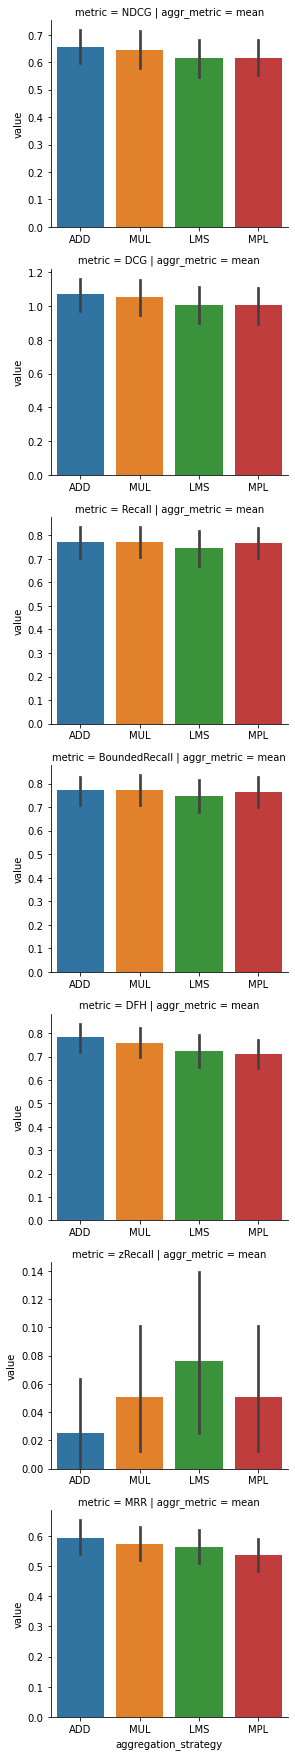

In [34]:
all_group_res = eval_df.groupby(['metric', 'aggr_metric', 'aggregation_strategy']).mean().reset_index()

g = sns.catplot(data=eval_df, row="metric", col="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey=False,
                   kind="bar",  height=3.5, aspect=1.2)

In [35]:
group_composition_DF = pd.DataFrame(group_composition).T
eval_df_with_group_info = group_composition_DF.join(eval_df.set_index("group_id"))
eval_df_with_group_info.head()

,group_size,group_members,group_similarity,metric,aggr_metric,value,aggregation_strategy,current_fold
1,4,"[26323, 42775, 41651, 32327]",0.48538,NDCG,mean,0.613147,ADD,0
1,4,"[26323, 42775, 41651, 32327]",0.48538,DCG,mean,1.000000,ADD,0
1,4,"[26323, 42775, 41651, 32327]",0.48538,Recall,mean,0.500000,ADD,0
1,4,"[26323, 42775, 41651, 32327]",0.48538,BoundedRecall,mean,0.500000,ADD,0
1,4,"[26323, 42775, 41651, 32327]",0.48538,DFH,mean,1.000000,ADD,0


### Metric variance per group size; keeping the aggregation strategies visible

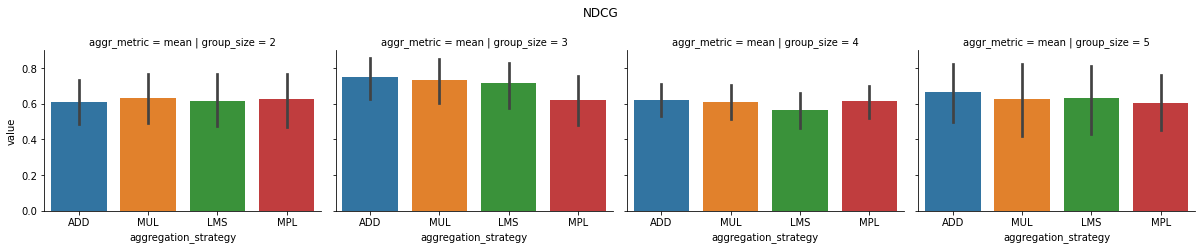

In [36]:
metric = "NDCG"
g = sns.catplot(data=eval_df_with_group_info.loc[eval_df_with_group_info.metric==metric], col="group_size", row="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey="row",
                   kind="bar",  height=3.5, aspect=1.2)
plt.suptitle(metric)
plt.tight_layout()


### Metric variance per group size; merging all aggregation strategies

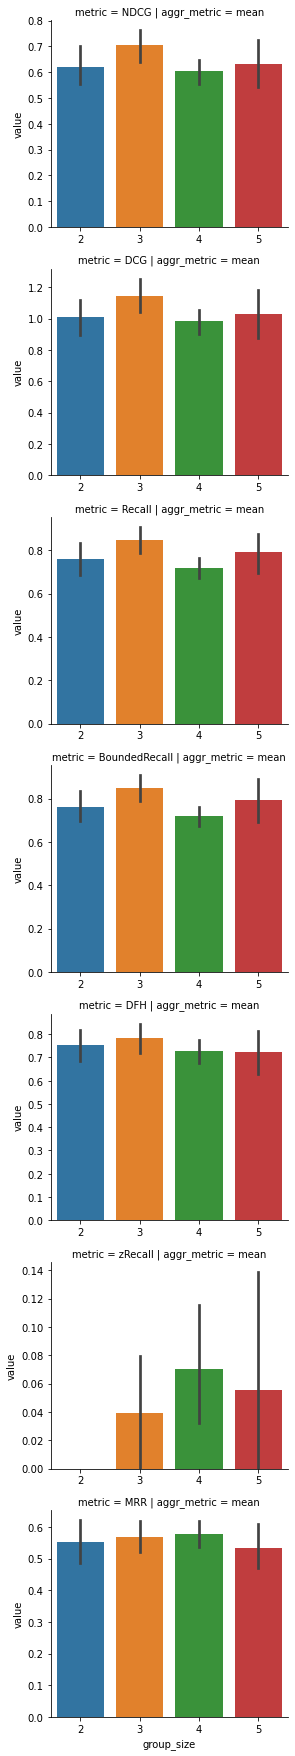

In [37]:
g = sns.catplot(data=eval_df_with_group_info, row="metric", col="aggr_metric", 
                   x="group_size", y="value", sharex=False, sharey=False,
                   kind="bar",  height=3.5, aspect=1.2)


### Metric variance per group size and group type; merging all aggregation strategies

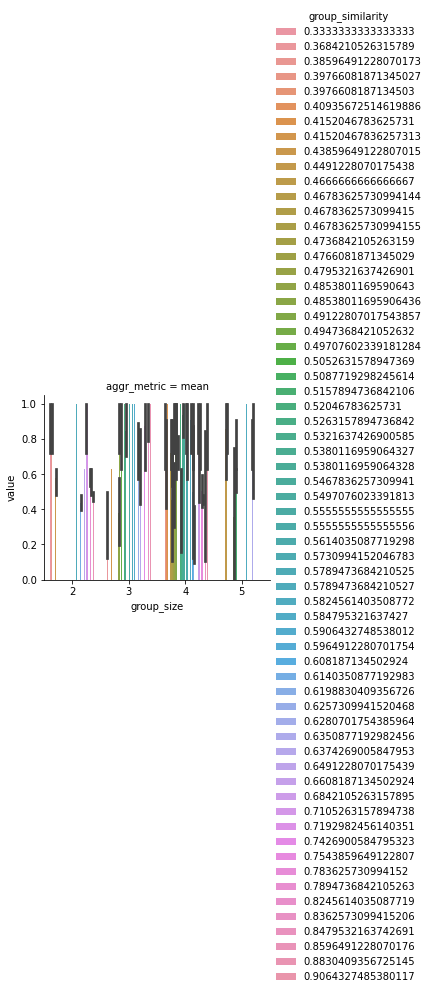

In [38]:
metric = "DFH"
g = sns.catplot(data=eval_df_with_group_info.loc[eval_df_with_group_info.metric==metric], hue="group_similarity", col="aggr_metric", 
                   x="group_size", y="value", sharex=False, sharey="row",
                   kind="bar",  height=3.5, aspect=1.2)

### Depict distribution of per-group values for all metrics

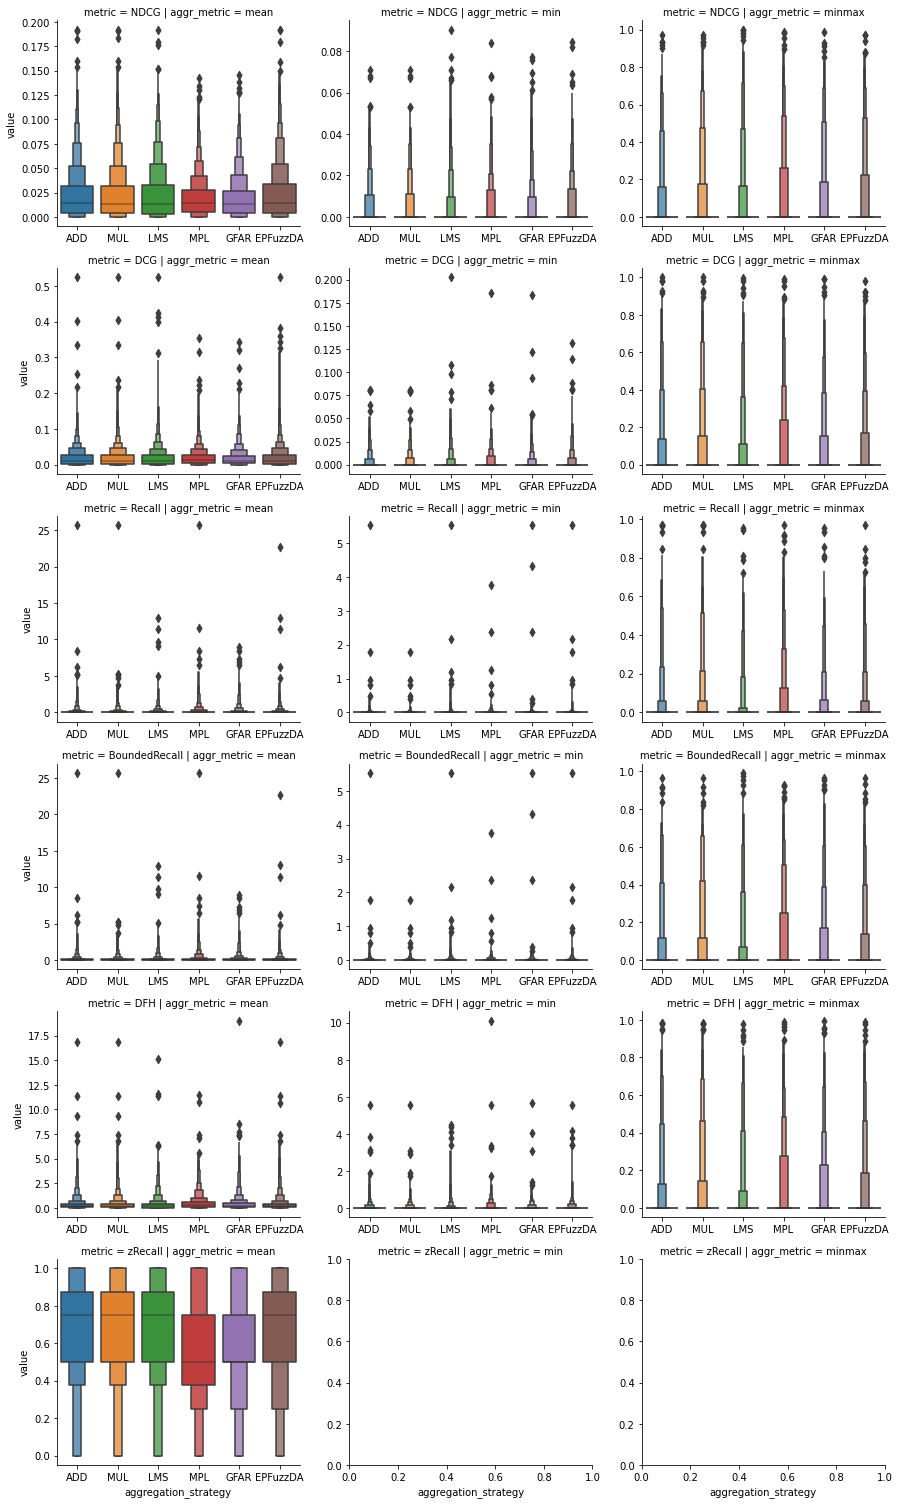

In [29]:
g = sns.catplot(data=eval_df, row="metric", col="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey=False,
                   kind="boxen",  height=3.5, aspect=1.2)

In [30]:
#group_folds = eval_df.groupby(['metric', 'aggr_metric', 'aggregation_strategy', 'group_id']).mean()
#display(group_folds['value'].reset_index().sort_values(by='group_id'))

In [31]:
#eval_df.groupby(['metric', 'aggr_metric', 'aggregation_strategy']).mean().head(50)

# Compare results of multiple evaluation runs
### Collect all results and extend eval_df with relevant evaluation parameters

In [32]:
#get all evaluation runs specified in valid_rows
def get_valid_evaluation_data(valid_rows):
    eval_df_list = []
    for res in valid_rows:
        path_to_eval_folder = preprocessed_dataset_folder + "/" + res
        eval_df = pickle.load(open(path_to_eval_folder+"/eval_df.pkl", "rb"))    
        for c in parameters_df_relevant.columns:
            eval_df[c]=parameters_df_relevant.loc[res,c]
        eval_df_list.append(eval_df)

    eval_df_concat = pd.concat(eval_df_list)
    return eval_df_concat

In [33]:
#select only those evaluation runs we consider interesting
valid_rows = parameters_df_relevant.index[5:]
parameters_df_relevant.loc[valid_rows]

,inverse_propensity_debiasing,inverse_propensity_gamma,binarize_feedback


In [34]:
eval_df_concat = get_valid_evaluation_data(valid_rows)
eval_df_concat.head(3)

ValueError: No objects to concatenate

### Coupled evaluation: effect of feedback binarization and inverse propensity debiasing

In [ ]:
metric = "DCG"
g = sns.catplot(data=eval_df_concat.loc[eval_df_concat.metric==metric], x="binarize_feedback", 
                col="aggr_metric", 
                hue="aggregation_strategy", y="value", sharex="col", sharey=False,
                kind="bar",  height=3.5, aspect=1.2)

In [ ]:
metric = "DCG"
g = sns.catplot(data=eval_df_concat.loc[eval_df_concat.metric==metric],  
                col="aggr_metric", hue="binarize_feedback", 
                x="aggregation_strategy", y="value", sharex=False, sharey=False,
                kind="bar",  height=3.5, aspect=1.2)

### Decoupled evaluation: effect of polarity debiasing

In [ ]:
valid_rows = parameters_df_relevant.index[2:5]
eval_df_concat = get_valid_evaluation_data(valid_rows)
parameters_df_relevant.loc[valid_rows]

In [ ]:

eval_df_concat.head(3)

In [ ]:
metric = "NDCG"
g = sns.catplot(data=eval_df_concat.loc[eval_df_concat.metric==metric], x="feedback_polarity_debiasing", 
                col="aggr_metric", 
                hue="aggregation_strategy", y="value", sharex=False, sharey="row",
                kind="bar",  height=3.5, aspect=1.2)

In [ ]:
valid_rows = parameters_df_relevant.index[0:2]
eval_df_concat = get_valid_evaluation_data(valid_rows)
parameters_df_relevant.loc[valid_rows]

In [ ]:
metric = "NDCG"
g = sns.catplot(data=eval_df_concat.loc[eval_df_concat.metric==metric], x="binarize_feedback_positive_threshold", 
                col="aggr_metric", 
                hue="aggregation_strategy", y="value", sharex=False, sharey=False,
                kind="bar",  height=3.5, aspect=1.2)